# About Wide & Deep Learning for RecSys

Original work: https://arxiv.org/pdf/1606.07792

Wide & Deep combines wide linear models for memorisation and deep neural networks for generalisation in a single jointly trained model. It aims to capture both memorisation and generalisation benefits for improved recommendations.

## Import packages & set-up

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import nltk
import re
import spacy
from wordcloud import WordCloud
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Flatten
from tensorflow.keras.models import Model
import torch
from scipy.sparse import coo_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim import corpora, models
from torch import nn, cat, mean

[nltk_data] Downloading package punkt to /Users/edwin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/edwin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/edwin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/edwin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
df = pd.read_csv('bt4222_dataset_21.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126144 entries, 0 to 126143
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   app_id                     126144 non-null  int64  
 1   app_name                   126144 non-null  object 
 2   review_id                  126144 non-null  int64  
 3   review                     126144 non-null  object 
 4   timestamp_updated          126144 non-null  int64  
 5   recommended                126144 non-null  bool   
 6   author.steamid             126144 non-null  int64  
 7   author.num_games_owned     126144 non-null  int64  
 8   author.playtime_at_review  126144 non-null  float64
 9   Release date               126144 non-null  object 
 10  Required age               126144 non-null  int64  
 11  Price                      126144 non-null  float64
 12  DLC count                  126144 non-null  int64  
 13  About the game             12

In [ ]:
# Group by 'author.steamid' and 'app_id' and count the interactions
interaction_counts = df.groupby(['author.steamid', 'app_id']).size().reset_index(name='interaction_count')

# Check if there are any pairs with interaction_count greater than 1
has_multiple_interactions = interaction_counts['interaction_count'].gt(1).any()

if has_multiple_interactions:
    print("There are some author.steamid values with multiple interactions for the same app_id.")
else:
    print("Each author.steamid has only one interaction with each app_id.")


Each author.steamid has only one interaction with each app_id.


## Processing dataframe

### Map user_id and app_id for sparse matrix formation

In [ ]:
# map each unique user_id and movie_id to a sequential index
user_id_mapping = {user_id: idx for idx, user_id in enumerate(df['author.steamid'].unique())}
movie_id_mapping = {movie_id: idx for idx, movie_id in enumerate(df['app_id'].unique())}

# apply
df['mapped_steam_id'] = df['author.steamid'].map(user_id_mapping)
df['mapped_app_id'] = df['app_id'].map(movie_id_mapping)

ratings_df = df[['mapped_steam_id',	'mapped_app_id', 'pred_rating',	'timestamp_updated', 'recommended', 'author.steamid', 'app_id']]
ratings_df.head()

,mapped_steam_id,mapped_app_id,pred_rating,timestamp_updated,recommended,author.steamid,app_id
0,0,0,4,1290229222,True,76561197967992446,4000
1,0,1,4,1290283941,True,76561197967992446,48700
2,1,1,4,1290984804,True,76561197968566119,48700
3,1,2,2,1291337732,True,76561197968566119,35140
4,1,3,4,1291338488,True,76561197968566119,240


### Game Features

In [ ]:
game_df = df.groupby('mapped_app_id').agg({
    'Price': 'first',
    'DLC count': 'first',
    'Required age': 'first',
    'item_review_count': 'first',
    'About the game': 'first'
}).reset_index()

game_df.rename(columns={
    'Price': 'price',
    'Required age': 'required_age',
    'DLC count': 'dlc_count',
    'About the game': 'about_the_game'
}, inplace=True)

game_df.head()

,mapped_app_id,price,dlc_count,required_age,item_review_count,about_the_game
0,0,9.99,0,0,2247,Garry's Mod is a physics sandbox. There aren't...
1,1,19.99,2,0,936,"In a land torn asunder by incessant warfare, i..."
2,2,3.99,0,0,597,Critically acclaimed Batman: Arkham Asylum ret...
3,3,9.99,0,0,931,THE NEXT INSTALLMENT OF THE WORLD'S # 1 ONLINE...
4,4,29.99,15,0,1374,The Flagship Turn-Based Strategy Game Returns ...


### User Features

In [ ]:
user_df = df.groupby('mapped_steam_id').agg({
    'author.num_games_owned': 'first',
    'author.playtime_at_review': 'sum', # get total playtime of user for all games
    'user_review_count': 'first'
}).reset_index()

user_df.rename(columns={
    'DLC count': 'dlc_count',
    'author.playtime_at_review': 'total_playtime'
}, inplace=True)

user_df.head()

,mapped_steam_id,author.num_games_owned,total_playtime,user_review_count
0,0,1037,56058.0,29
1,1,587,101635.0,23
2,2,2646,105806.0,32
3,3,2295,35248.0,28
4,4,581,238723.0,22


## Feature Engineering

### Topic label for each Game Description using LDA

In [ ]:
# clean about the game
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

add_stopwords = ['game', 'player', 'play', 'gameplay', 'game','experience','system','level','mode','way']
stop_words.update(add_stopwords)

def clean_text(text):

    text = text.lower()

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    tokens = word_tokenize(text)

    # remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    tokens = [word for word in tokens if word not in stop_words]

    # Join tokens back into a single string
    cleaned_text = ' '.join(tokens)

    return cleaned_text

In [ ]:
# keep unique games only
unique_games = game_df[['mapped_app_id', 'about_the_game']].drop_duplicates().reset_index(drop=True)

# clean game description
unique_games['cleaned_description'] = unique_games['about_the_game'].apply(clean_text)

# tokenize
unique_games['tokens'] = unique_games['cleaned_description'].apply(lambda x: x.split())

# lda

# build dict n corpus
dict = corpora.Dictionary(unique_games['tokens'])
corpus = [dict.doc2bow(tokens) for tokens in unique_games['tokens']]

# train lda model
num_topics = 30
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dict, passes=25)

# test topics
print("\nTopics generated by LDA:")
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx + 1}: {topic}")

# Get topic distribution for each document
def get_topic_distribution(text):
    bow = dict.doc2bow(text)
    topic_dist = lda_model.get_document_topics(bow, minimum_probability=0)
    return [prob for _, prob in topic_dist]


# apply topic distribution to each game
unique_games['topic_distribution'] = unique_games['tokens'].apply(get_topic_distribution)

# get most likely topic for that game
unique_games['topic'] = unique_games['topic_distribution'].apply(lambda x: np.argmax(x))

# merge game topic back to reviews df
ratings_df = ratings_df.merge(unique_games[['mapped_app_id', 'topic']], on='mapped_app_id', how='left')


Topics generated by LDA:
Topic 1: 0.015*"new" + 0.009*"character" + 0.009*"china" + 0.009*"enemy" + 0.008*"three" + 0.007*"war" + 0.006*"city" + 0.005*"survival" + 0.005*"world" + 0.005*"kingdom"
Topic 2: 0.014*"ori" + 0.008*"wisp" + 0.007*"security" + 0.006*"window" + 0.006*"come" + 0.006*"want" + 0.006*"story" + 0.006*"trick" + 0.006*"sequel" + 0.006*"emotional"
Topic 3: 0.010*"ship" + 0.008*"galaxy" + 0.007*"new" + 0.007*"raft" + 0.006*"survival" + 0.006*"find" + 0.006*"weapon" + 0.006*"perhaps" + 0.005*"make" + 0.005*"resource"
Topic 4: 0.011*"isaac" + 0.010*"world" + 0.009*"war" + 0.008*"call" + 0.007*"eye" + 0.007*"duty" + 0.006*"enemy" + 0.006*"new" + 0.006*"become" + 0.005*"feature"
Topic 5: 0.011*"new" + 0.008*"siege" + 0.008*"weapon" + 0.007*"every" + 0.007*"around" + 0.007*"demon" + 0.006*"girl" + 0.006*"assassin" + 0.006*"defense" + 0.005*"ancient"
Topic 6: 0.016*"world" + 0.012*"character" + 0.008*"new" + 0.006*"use" + 0.006*"hexagon" + 0.005*"feature" + 0.005*"get" + 0.0

### Cluster label for Games

Elbow Method to determine the number of clusters without PCA to be formed:


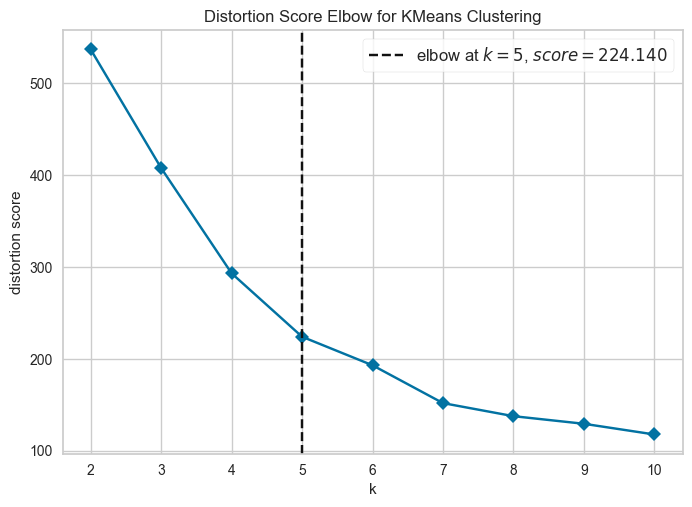

[2 1 1 1 2 1 1 2 2 1 2 4 4 1 1 4 4 1 1 1 1 1 4 4 1 1 1 2 0 0 1 4 1 2 1 1 1
 1 1 1 2 0 4 4 1 1 1 1 1 2 1 1 2 1 2 2 1 2 1 2 4 2 1 4 1 0 1 2 1 2 1 2 4 0
 0 4 1 1 1 1 2 0 0 4 0 0 1 4 4 1 4 0 1 1 1 1 1 1 0 2 0 1 1 1 1 0 1 1 1 4 0
 0 4 1 1 1 1 1 1 1 4 4 1 1 1 4 1 0 1 4 0 3 1 1 4 0 1 0 0 4 3 0 1 1 1 1 4 4
 1 1 4 0 1 1 1 0 1 1 0 4 0 1 0 4 0 1]


In [ ]:
# Scale all the numerical features in game_df

scaler = StandardScaler()
# extract out relevant columns used for clustering
game_df_cluster_columns = game_df[['price',	'dlc_count', 'required_age',	'item_review_count']]
scaler.fit(game_df_cluster_columns)
scaled_game_df = pd.DataFrame(scaler.transform(game_df_cluster_columns), columns= game_df_cluster_columns.columns )
scaled_game_df.describe()

# Kmeans on game_df without PCA

print('Elbow Method to determine the number of clusters without PCA to be formed:')
Elbow_M = KElbowVisualizer(
    KMeans(random_state=0),
    k=10,
    locate_elbow=True,
    timings=False
)

Elbow_M.fit(scaled_game_df)
Elbow_M.show()

# Initialize the Kmeans Clustering model with 5 clusters
kmeans_df = KMeans(n_clusters=5, random_state=0)

# Fit the model and predict clusters on df columns
labels = kmeans_df.fit_predict(scaled_game_df)

# add cluster 0-4 to game_df
game_df["game_cluster"] = labels
print(labels)


### Cluster label for Users

Elbow Method to determine the number of clusters without PCA to be formed:


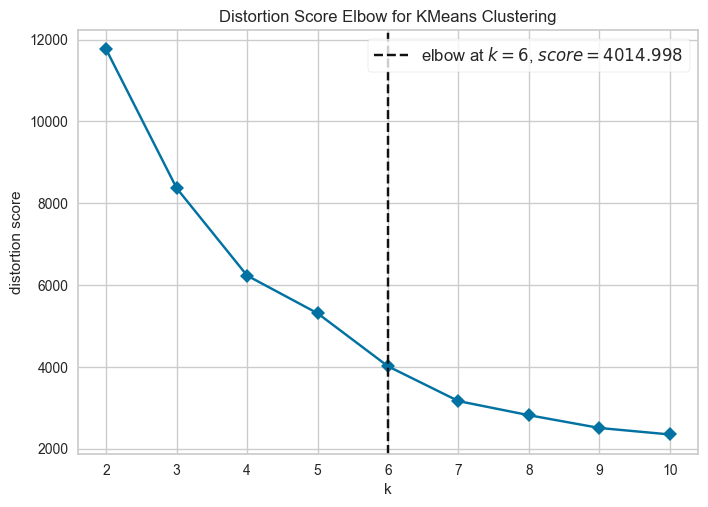

[4 0 4 ... 1 0 1]


In [ ]:
# Scale all the numerical features in user_df

scaler = StandardScaler()
# extract out relevant columns used for clustering
scaled_user_df_columns = user_df[['author.num_games_owned',	'total_playtime',	'user_review_count']]
scaler.fit(scaled_user_df_columns)
scaled_user_df = pd.DataFrame(scaler.transform(scaled_user_df_columns), columns= scaled_user_df_columns.columns )
scaled_user_df.describe()

# Kmeans on game_df without PCA

print('Elbow Method to determine the number of clusters without PCA to be formed:')
Elbow_M = KElbowVisualizer(
    KMeans(random_state=0),
    k=10,
    locate_elbow=True,
    timings=False
)

Elbow_M.fit(scaled_user_df)
Elbow_M.show()

# Initialize the Kmeans Clustering model with 6 clusters
kmeans_df = KMeans(n_clusters=6, random_state=0)

# Fit the model and predict clusters on df columns
labels = kmeans_df.fit_predict(scaled_user_df)

# add cluster 0-5 to user_df
user_df["user_cluster"] = labels
print(labels)

### List of user's previously interacted games

In [ ]:
# Sort ratings by user and timestamp
ratings_df = ratings_df.sort_values(['mapped_steam_id', 'timestamp_updated']).reset_index(drop=True)

# Initialize an empty list for storing previous games
ratings_df['prev_games'] = [[] for _ in range(len(ratings_df))]

# Iterate over each unique user to fill in 'prev_games' column
for user_id in ratings_df['mapped_steam_id'].unique():
    user_indices = ratings_df[ratings_df['mapped_steam_id'] == user_id].index
    prev_games = []
    for idx in user_indices:
        ratings_df.at[idx, 'prev_games'] = prev_games.copy()
        prev_games.append(str(ratings_df.at[idx, 'mapped_app_id']))
        ratings_df.at[idx, 'prev_games'] = prev_games.copy()


In [ ]:
# check
sample = ratings_df[ratings_df['mapped_steam_id'] == 0]
sample.head()

,mapped_steam_id,mapped_app_id,pred_rating,timestamp_updated,recommended,author.steamid,app_id,topic,prev_games
0,0,0,4,1290229222,True,76561197967992446,4000,11,[0]
1,0,1,4,1290283941,True,76561197967992446,48700,19,"[0, 1]"
2,0,6,4,1298399205,True,76561197967992446,420,14,"[0, 1, 6]"
3,0,8,2,1306119630,True,76561197967992446,105600,9,"[0, 1, 6, 8]"
4,0,9,4,1317861714,True,76561197967992446,113200,3,"[0, 1, 6, 8, 9]"


In [ ]:
# Merge game and user data into the main dataset
ratings_df = ratings_df.merge(game_df, on='mapped_app_id', how='left').merge(user_df, on='mapped_steam_id', how='left')
ratings_df = ratings_df.drop(columns=['about_the_game'])
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126144 entries, 0 to 126143
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   mapped_steam_id         126144 non-null  int64  
 1   mapped_app_id           126144 non-null  int64  
 2   pred_rating             126144 non-null  int64  
 3   timestamp_updated       126144 non-null  int64  
 4   recommended             126144 non-null  bool   
 5   author.steamid          126144 non-null  int64  
 6   app_id                  126144 non-null  int64  
 7   topic                   126144 non-null  int64  
 8   prev_games              126144 non-null  object 
 9   price                   126144 non-null  float64
 10  dlc_count               126144 non-null  int64  
 11  required_age            126144 non-null  int64  
 12  item_review_count       126144 non-null  int64  
 13  game_cluster            126144 non-null  int32  
 14  author.num_games_own

### Scale numerical features

In [ ]:
# Scale numerical features
numerical_cols = ['pred_rating', 'price', 'dlc_count', 'required_age', 'item_review_count', 'author.num_games_owned', 'total_playtime', 'user_review_count']
scaler = StandardScaler()
ratings_df[numerical_cols] = scaler.fit_transform(ratings_df[numerical_cols])

### One-hot encode categorical features

In [ ]:
ratings_df = pd.get_dummies(ratings_df, columns=['topic', 'user_cluster', 'game_cluster'])
ratings_df = ratings_df.applymap(lambda x: int(x) if isinstance(x, bool) else x)

/var/folders/bv/mclm3yzx5vb_ndphg4qzkzfw0000gn/T/ipykernel_17382/530771997.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ratings_df = ratings_df.applymap(lambda x: int(x) if isinstance(x, bool) else x)


### Functions to convert into tensor

In [ ]:
def get_coo_indexes(lil):
    rows = []
    cols = []
    for i, el in enumerate(lil):
        if type(el)!=list:
            el = [el]
        for j in el:
            rows.append(i)
            cols.append(j)
    return rows, cols

def get_sparse_features(series, shape):
    coo_indexes = get_coo_indexes(series.tolist())
    sparse_df = coo_matrix((np.ones(len(coo_indexes[0])), (coo_indexes[0], coo_indexes[1])), shape=shape)
    return sparse_df

In [ ]:
# test: get sparse matrix of total rows = no. of user-item interactions, total cols = no. of games
get_sparse_features(ratings_df['prev_games'], (len(ratings_df), ratings_df['mapped_app_id'].max() + 1)).shape

(126144, 166)

## Train-Test Split

In [ ]:
# Sort ratings by user and timestamp (assume pred_rating represents chronological order)
ratings_df = ratings_df.sort_values(['mapped_steam_id', 'timestamp_updated']).reset_index(drop=True)

# split data into train and test, preprocessing for evaluation of model
split = 0.8

# Get unique user IDs
unique_users = ratings_df['mapped_steam_id'].unique()

train_data = []
test_data = []

# Split data for each user
for user_id in unique_users:
    user_data = ratings_df[ratings_df['mapped_steam_id'] == user_id]
    split_idx = round(len(user_data) * split)
    train_data.append(user_data.iloc[:split_idx])
    test_data.append(user_data.iloc[split_idx:])

train = pd.concat(train_data)
test = pd.concat(test_data)

print(train.shape)
print(test.shape)

(101072, 55)
(25072, 55)


In [ ]:
# Group by 'mapped_steam_id' in each dataset and convert to dictionaries of sets
train_apps_by_user = train.groupby('mapped_steam_id')['mapped_app_id'].apply(set).to_dict()
test_apps_by_user = test.groupby('mapped_steam_id')['mapped_app_id'].apply(set).to_dict()

overlapping_apps_by_user = {}

for user_id, train_apps in train_apps_by_user.items():
    # Check if the user exists in the test set
    if user_id in test_apps_by_user:
        # Find intersection of app IDs between train and test for this user
        overlap = train_apps.intersection(test_apps_by_user[user_id])
        if overlap:
            overlapping_apps_by_user[user_id] = overlap

if overlapping_apps_by_user:
    print("there are users that interacted with games in both train and test set.")
else:
    print("No overlapping 'mapped_app_id' values for any 'mapped_steam_id' between train and test.")

No overlapping 'mapped_app_id' values for any 'mapped_steam_id' between train and test.


In [ ]:
# train data
X_train = train.drop(['mapped_steam_id',	'mapped_app_id',	'pred_rating',	'timestamp_updated',	'recommended',	'author.steamid',	'app_id', 'prev_games'],
                          axis=1)
prev_games_train = get_sparse_features(train['prev_games'], (len(train), ratings_df['mapped_app_id'].max()+1)) # in sparse format
y_train = train['recommended']

# test data
X_test = test.drop(['mapped_steam_id',	'mapped_app_id',	'pred_rating',	'timestamp_updated',	'recommended',	'author.steamid',	'app_id', 'prev_games'],
                          axis=1)
prev_games_test = get_sparse_features(test['prev_games'], (len(test), ratings_df['mapped_app_id'].max()+1)) # in sparse format
y_test = test['recommended']

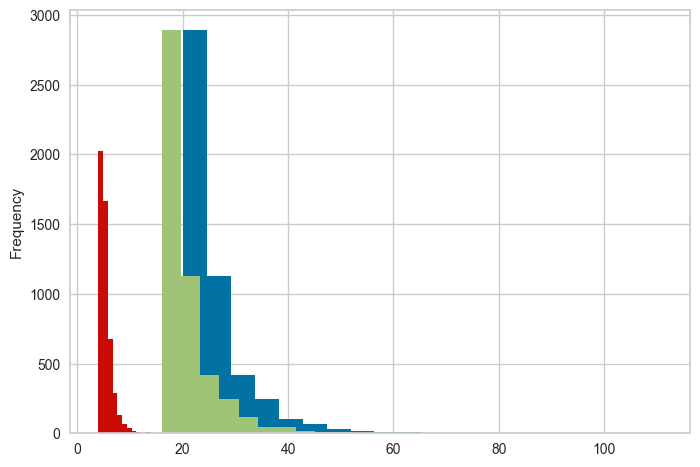

In [ ]:
# check distribution of games for train, test and original dataset
for df in [ratings_df, train, test]:
    df.groupby('mapped_steam_id')['mapped_app_id'].count().plot.hist(bins=20)

## Model Generation

In [ ]:
# returns a numpy array where each row represents a user’s game history of uniform length.
def sparse_to_idx(data, pad_idx=-1):
    indexes = data.nonzero() # returns indices of non-zero entries in the sparse feature
    indexes_df = pd.DataFrame()
    indexes_df['rows'] = indexes[0]
    indexes_df['cols'] = indexes[1]
    mdf = indexes_df.groupby('rows').apply(lambda x: x['cols'].tolist())
    max_len = mdf.apply(lambda x: len(x)).max()
    # padded format is suitable for passing into an embedding layer in the model.
    return mdf.apply(lambda x: pd.Series(x + [pad_idx] * (max_len - len(x)))).values

def idx_to_sparse(idx, sparse_dim):
    sparse = np.zeros(sparse_dim)
    sparse[int(idx)] = 1
    return pd.Series(sparse, dtype=int)

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Prepare Pytorch Tensor for input as embeddings

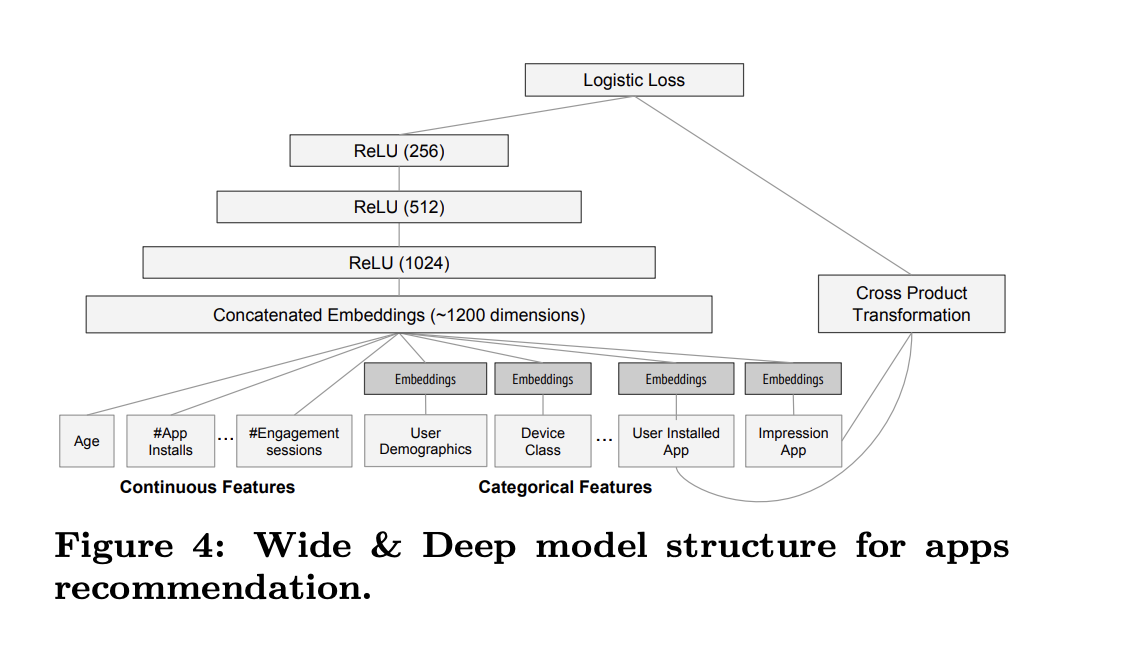

In [ ]:
# Train portion
PAD_IDX = 0
# tensor with numerical/categorical features
X_train_tensor = torch.Tensor(X_train.values).to(device) # x_train shape: (101072, 47)

# Dense binary tensor where each entry indicates whether a game was played by the user. Shape is (num_users, num_games)
games_train_tensor = torch.sparse_coo_tensor(
    indices = prev_games_train # prev_games_train shape: (101072, 166)
    .nonzero(),
    values = [1]*len(prev_games_train.nonzero()[0]),
    size = prev_games_train.shape # prev_games_train shape: (101072, 166)
).to_dense().to(device)

# Padded sequences of game indices for each user, which can be used as input to embedding layers. Shape is (num_users, max_sequence_length).
games_train_idx = torch.Tensor(
    sparse_to_idx(prev_games_train # prev_games_train shape: (101072, 166)
                  , pad_idx=PAD_IDX),
).long().to(device)

# target
target_train = torch.Tensor(y_train # y_train shape: (101072,)
                            .values).long().to(device)

/var/folders/bv/mclm3yzx5vb_ndphg4qzkzfw0000gn/T/ipykernel_17382/1091903122.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  games_train_tensor = torch.sparse_coo_tensor(
/var/folders/bv/mclm3yzx5vb_ndphg4qzkzfw0000gn/T/ipykernel_17382/405361304.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mdf = indexes_df.groupby('rows').apply(lambda x: x['cols'].tolist())


In [ ]:
class WideAndDeep(nn.Module):
    def __init__(
        self,
        continious_feature_shape,   # number of continuous features
        embed_size,                 # size of embedding for binary features
        embed_dict_len,             # number of unique binary features (games)
        pad_idx                     # padding index
    ):
        super(WideAndDeep, self).__init__()
        self.embed = nn.Embedding(embed_dict_len, embed_size, padding_idx=pad_idx)

        # Define layers for processing continuous and embedded features
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(embed_size + continious_feature_shape, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        # Final layer: only take `256` output dimension from the deep path
        self.head = nn.Linear(256, embed_dict_len)

    def forward(self, continious, binary, binary_idx):
        # Embed sequence of indices
        binary_embed = self.embed(binary_idx)
        binary_embed_mean = mean(binary_embed, dim=1)  # Shape: (batch_size, embed_size)

        # Concatenate continuous features with the embedded features
        deep_input = cat((continious, binary_embed_mean), dim=1)  # Shape: (batch_size, embed_size + continuous_feature_shape)

        # Process with the deep layers
        deep_logits = self.linear_relu_stack(deep_input)  # Output shape: (batch_size, 256)

        # Pass only deep_logits to the head layer for final predictions
        total_logits = self.head(deep_logits)  # Output shape: (batch_size, embed_dict_len)

        return total_logits


In [ ]:
# define model
model = WideAndDeep(
    X_train.shape[1],
    16,
    ratings_df['mapped_app_id'].nunique() + 1, # 167
    PAD_IDX
).to(device)
print(model)

WideAndDeep(
  (embed): Embedding(167, 16, padding_idx=0)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=63, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
  )
  (head): Linear(in_features=256, out_features=167, bias=True)
)


### Model Training

In [ ]:
EPOCHS = 10
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in range(EPOCHS):
    model.train()
    pred_train = model(X_train_tensor, games_train_tensor, games_train_idx)
    loss_train = loss_fn(pred_train, target_train) # cross entropy loss for trng

    # backprop
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    print(f"Epoch {t}")
    print(f"Train loss: {loss_train:>7f}")

Epoch 0
Train loss: 5.106221
Epoch 1
Train loss: 4.876366
Epoch 2
Train loss: 4.525141
Epoch 3
Train loss: 3.957963
Epoch 4
Train loss: 3.136862
Epoch 5
Train loss: 2.069539
Epoch 6
Train loss: 0.929069
Epoch 7
Train loss: 0.204654
Epoch 8
Train loss: 0.022284
Epoch 9
Train loss: 0.001778


### Model evaluation - F1 score, Recall, Precision and NDCG where @ K = 4

In [ ]:
# tensor with continuous features
X_test_tensor = torch.Tensor(X_test.values).to(device)

# tensor with continious features
games_test_tensor = torch.sparse_coo_tensor(
    indices = prev_games_test.nonzero(),
    values = [1]*len(prev_games_test.nonzero()[0]),
    size = prev_games_test.shape
).to_dense().to(device)

# tensor with binary features
games_test_idx = torch.Tensor(
    sparse_to_idx(prev_games_test, pad_idx=PAD_IDX),
).long().to(device)

# target
target_test = torch.Tensor(y_test.values).long().to(device)

/var/folders/bv/mclm3yzx5vb_ndphg4qzkzfw0000gn/T/ipykernel_17382/405361304.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mdf = indexes_df.groupby('rows').apply(lambda x: x['cols'].tolist())


In [ ]:
def calculate_metrics_for_user(actual, recommended, k=4):
    actual_set = set(actual)
    recommended_at_k = recommended[:k]

    # precision@k
    hits_at_k = sum([1 for item in recommended_at_k if item in actual_set])
    precision_at_k = hits_at_k / k

    # recall@K
    recall_at_k = hits_at_k / len(actual_set) if actual_set else 0

    # f1@K
    f1_at_k = (2 * precision_at_k * recall_at_k) / (precision_at_k + recall_at_k) if (precision_at_k + recall_at_k) > 0 else 0

    # NDCG@K
    dcg = sum([1 / np.log2(idx + 2) for idx, item in enumerate(recommended_at_k) if item in actual_set])
    idcg = sum([1 / np.log2(idx + 2) for idx in range(min(len(actual_set), k))])
    ndcg_at_k = dcg / idcg if idcg > 0 else 0

    return precision_at_k, recall_at_k, f1_at_k, ndcg_at_k

In [ ]:
test = test.reset_index(drop=True) # ensure both have same indices if not cannot conver to pytorch
X_test = X_test.reset_index(drop=True)

precision_list = []
recall_list = []
f1_list = []
ndcg_list = []

# unique userid from test
test_user_ids = test['mapped_steam_id'].unique()

# for each user in test
for user_id in test_user_ids:
    print(f'{user_id}/{len(test_user_ids)}')

    # actual games the user interacted with
    test_data_of_user = test[test['mapped_steam_id'] == user_id]

    # check if test_data_of_user is empty
    if test_data_of_user.empty:
        continue

    actual_games_data = test_data_of_user[test_data_of_user['recommended'] == 1]
    actual_games = actual_games_data['mapped_app_id'].tolist()

    # get the index of the first row for this user in test
    user_index = test_data_of_user.index[0]

    # extract nuemrical features for the user
    user_continuous_features = X_test.loc[user_index].values
    user_continuous = torch.Tensor(user_continuous_features).unsqueeze(0).to(device)

    # extract the user's game history from `prev_games_test`
    user_prev_games = prev_games_test.getrow(user_index).nonzero()[1]
    num_games = prev_games_test.shape[1]
    user_games_tensor = torch.zeros((1, num_games)).to(device)
    user_games_tensor[0, user_prev_games] = 1

    # pad sequence of game indices for embedding
    max_sequence_length = 4
    user_games_idx = torch.full((1, max_sequence_length), PAD_IDX, dtype=torch.long).to(device)
    num_played_games = min(len(user_prev_games), max_sequence_length)
    user_games_idx[0, :num_played_games] = torch.tensor(user_prev_games[:num_played_games], dtype=torch.long)

    # get predictions of all games for this user
    model.eval()
    with torch.no_grad():
        user_prediction = model(user_continuous, user_games_tensor, user_games_idx)

    # top-K recommendations
    K = 4
    _, recommended_games = torch.topk(user_prediction, K, dim=1)
    recommended_games = recommended_games.cpu().numpy().tolist()[0]

    # get metrics for this user
    precision_at_k, recall_at_k, f1_at_k, ndcg_at_k = calculate_metrics_for_user(actual_games, recommended_games, k=K)

    precision_list.append(precision_at_k)
    recall_list.append(recall_at_k)
    f1_list.append(f1_at_k)
    ndcg_list.append(ndcg_at_k)

# get average metrics across all users
average_precision_at_k = np.mean(precision_list)
average_recall_at_k = np.mean(recall_list)
average_f1_at_k = np.mean(f1_list)
average_ndcg_at_k = np.mean(ndcg_list)

print(f"Average Evaluation Metrics @K={K}:")
print(f"Precision@{K}: {average_precision_at_k:.4f}")
print(f"Recall@{K}: {average_recall_at_k:.4f}")
print(f"F1@{K}: {average_f1_at_k:.4f}")
print(f"NDCG@{K}: {average_ndcg_at_k:.4f}")


0/4935
1/4935
2/4935
3/4935
4/4935
5/4935
6/4935
7/4935
8/4935
9/4935
10/4935
11/4935
12/4935
13/4935
14/4935
15/4935
16/4935
17/4935
18/4935
19/4935
20/4935
21/4935
22/4935
23/4935
24/4935
25/4935
26/4935
27/4935
28/4935
29/4935
30/4935
31/4935
32/4935
33/4935
34/4935
35/4935
36/4935
37/4935
38/4935
39/4935
40/4935
41/4935
42/4935
43/4935
44/4935
45/4935
46/4935
47/4935
48/4935
49/4935
50/4935
51/4935
52/4935
53/4935
54/4935
55/4935
56/4935
57/4935
58/4935
59/4935
60/4935
61/4935
62/4935
63/4935
64/4935
65/4935
66/4935
67/4935
68/4935
69/4935
70/4935
71/4935
72/4935
73/4935
74/4935
75/4935
76/4935
77/4935
78/4935
79/4935
80/4935
81/4935
82/4935
83/4935
84/4935
85/4935
86/4935
87/4935
88/4935
89/4935
90/4935
91/4935
92/4935
93/4935
94/4935
95/4935
96/4935
97/4935
98/4935
99/4935
100/4935
101/4935
102/4935
103/4935
104/4935
105/4935
106/4935
107/4935
108/4935
109/4935
110/4935
111/4935
112/4935
113/4935
114/4935
115/4935
116/4935
117/4935
118/4935
119/4935
120/4935
121/4935
122/4935
123